In [1]:
import jax
import jax.numpy as jnp
import jax.random as jrandom
import matplotlib.pyplot as plt
import diffrax
import multi_gp
from scipy.linalg import solve_continuous_are
import time
import sympy
from sympy.core.rules import Transform

In [2]:
_itemsize_kind_type = {
    (1, "i"): jnp.int8,
    (2, "i"): jnp.int16,
    (4, "i"): jnp.int32,
    (8, "i"): jnp.int64,
    (2, "f"): jnp.float16,
    (4, "f"): jnp.float32,
    (8, "f"): jnp.float64,
}
import jax.lax as lax

def force_bitcast_convert_type(val, new_type=jnp.int32):
    val = jnp.asarray(val)
    intermediate_type = _itemsize_kind_type[new_type.dtype.itemsize, val.dtype.kind]
    val = val.astype(intermediate_type)
    return lax.bitcast_convert_type(val, new_type)

## Environments

In [3]:
class Partial_SHO:
    def __init__(self, key, dt, omega_0, sigma, obs_noise):
        self.n_obs = 1
        self.n_var = 2
        self.omega_0 = omega_0
        self.sigma = sigma
        self.obs_noise = obs_noise
        
        self.A = jnp.array([[0,1],[-(self.omega_0**2),0]])
        self.b = jnp.array([[0.0,1.0]]).T
        self.G = jnp.array([[0,0],[0,1]])
        self.V = self.sigma*self.G

        self.C = jnp.array([[1,0]])
        self.W = self.obs_noise*jnp.array([1])

        self.key = key
        self.dt = dt

    def f_obs(self,t,x):
        key = jrandom.fold_in(self.key, force_bitcast_convert_type(t))
        return self.C@x + jrandom.normal(key, shape=(self.n_obs,))*self.W

    def compute_riccati(self, objective):
        V = solve_continuous_are(self.A,self.b,objective.Q,objective.R)
        L = 1/objective.R@self.b.T@V
        return L

    def drift(self, t, x, args):
        return self.A@x + self.b@args
    
    def diffusion(self, t, x, args):
        return self.V

In [4]:
class Observable_SHO:
    def __init__(self, key, dt, omega_0, sigma, obs_noise):
        self.n_obs = 2
        self.n_var = 2
        self.omega_0 = omega_0
        self.sigma = sigma
        self.obs_noise = obs_noise

        self.A = jnp.array([[0,1],[-(self.omega_0**2),-0.1]])
        self.b = jnp.array([[0.0,1.0]]).T
        self.G = jnp.array([[0,0],[0,1]])
        self.V = self.sigma*self.G

        # self.C = jnp.array([[1,1]])
        self.C = jnp.eye(self.n_obs)
        self.W = self.obs_noise*jnp.ones(self.n_obs)

        self.dt = dt
        self.key = key

    def f_obs(self,t,x):
        key = jrandom.fold_in(self.key, force_bitcast_convert_type(t))
        return self.C@x + jrandom.normal(key,shape=(self.n_obs,))*self.W

    def compute_riccati(self, objective):
        V = solve_continuous_are(self.A,self.b,objective.Q,objective.R)
        L = 1/objective.R@self.b.T@V
        return L

    def drift(self, t, x, args):
        return self.A@x + self.b@args#, self.f_obs(t,x)
    
    def diffusion(self, t, x, args):
        return self.V

In [5]:
class Objective_function:
    def __init__(self, A, B):
        self.q = self.r = 0.5
        self.Q = jnp.array([[self.q,0],[0,0]])
        self.R = jnp.array([self.r])
        self.A = A
        self.B = B

    def get_rewards(self, x, u, target):
        x_d = jnp.array([target,0])
        u_d = -jnp.linalg.pinv(self.B)@self.A@x_d
        rewards = jax.vmap(lambda _x, _u: (_x-x_d).T@self.Q@(_x-x_d) + (_u-u_d)*self.R*(_u-u_d))(x,u)
        return -jnp.cumsum(rewards)

## Controllers

In [6]:
class LQG_DE:
    def __init__(self, env, L):
        self.env = env
        self.L = L
        self.mu = jnp.array([0.0,0.0])
        self.P = jnp.eye(2)

    def drift(self, t, variables, args):
        x_star, u_star = args
        x = variables[:2]

        v = jnp.array([variables[2]])
        
        u = v + self.L@x_star + u_star[0]

        mu = variables[3:5]
        P = variables[5:]
        P = P.reshape(2,2)

        K = P@self.env.C.T*(1/self.env.W)
        dx, y = self.env.drift(t,x,u)
        dmu = self.env.A@mu + self.env.b@u + K@(y-self.env.C@mu)
        dP = self.env.A@P + P@self.env.A.T - K@self.env.C@P +self.env.G*self.env.V@self.env.G

        dv = jnp.expand_dims(-self.L@(dmu),0)
        return jnp.concatenate([dx, dv, dmu, jnp.ravel(dP)])

    #apply process noise only on x
    def diffusion(self, t, variables, args):
        x = variables[:2]
        return jnp.concatenate([self.env.diffusion(t,x,args),jnp.zeros((1,2)),jnp.zeros((2,2)),jnp.zeros((4,2))])

    def solve(self, ts, x0, key, target):
        solver = diffrax.Euler()
        dt0 = 0.1
        saveat = diffrax.SaveAt(ts=ts)

        x_star = jnp.array([target,-0])
        u_star = -jnp.linalg.pinv(self.env.b)@self.env.A@x_star 

        brownian_motion = diffrax.VirtualBrownianTree(ts[0], ts[-1], tol=1e-3, shape=(2,), key=key) #define process noise
        system = diffrax.MultiTerm(diffrax.ODETerm(self.drift), diffrax.ControlTerm(self.diffusion, brownian_motion))

        init = jnp.concatenate([x0, -jnp.expand_dims(self.L@self.mu,0), self.mu, jnp.ravel(self.P)])

        sol = diffrax.diffeqsolve(
            system, solver, ts[0], ts[-1], dt0, init, saveat=saveat, args=(x_star, u_star)
        )

        x = sol.ys[:,:2]
        u = sol.ys[:,2] + self.L@x_star + u_star[0]
        mu = sol.ys[:,3:5]
        P = sol.ys[:,5:]
        y = jax.vmap(self.env.f_obs)(ts, x)

        return x, y, u, mu, P

In [7]:
class LQG:
    def __init__(self, env, L):
        self.env = env
        self.L = L
        self.mu = jnp.array([0.0,0.0])

        self.P = jnp.eye(2)*0.75
        # self.P = self.env.A@self.P + self.P@self.env.A.T+self.P@self.env.C.T*(1/self.env.W)@self.env.C@self.P+self.env.G*self.env.V@self.env.G
        # self.K = self.P@self.env.C.T*(1/self.env.W)
        
    def drift(self, t, variables, args):
        x_star, u_star = args
        x = variables[:2]
        mu = variables[2:4]
        P = variables[4:].reshape(2,2)
        
        y = self.env.f_obs(t,x)
        u = jnp.array([-self.L@(mu-x_star) + u_star[0]])

        K = P@self.env.C.T*(1/self.env.W)

        dx = self.env.drift(t,x,u)
        dmu = self.env.A@mu + self.env.b@u + K@(y-self.env.C@mu)
        dP = self.env.A@P + P@self.env.A.T-K@self.env.C@P+self.env.G*self.env.V@self.env.G
        return jnp.concatenate([dx, dmu, jnp.ravel(dP)])

    #apply process noise only on x
    def diffusion(self, t, variables, args):
        x = variables[:2]
        return jnp.concatenate([self.env.diffusion(t,x,args),jnp.zeros((2,2)),jnp.zeros((4,2))])

    def solve(self, ts, x0, key, target):
        solver = diffrax.Euler()
        dt0 = 0.1
        saveat = diffrax.SaveAt(ts=ts)

        x_star = jnp.array([target,-0])
        u_star = -jnp.linalg.pinv(self.env.b)@self.env.A@x_star 

        brownian_motion = diffrax.UnsafeBrownianPath(shape=(2,), key=key) #define process noise
        system = diffrax.MultiTerm(diffrax.ODETerm(self.drift), diffrax.ControlTerm(self.diffusion, brownian_motion))

        init = jnp.concatenate([x0, self.mu, jnp.ravel(self.P)])

        sol = diffrax.diffeqsolve(
            system, solver, ts[0], ts[-1], dt0, init, saveat=saveat, args=(x_star, u_star), adjoint=diffrax.DirectAdjoint()
        )

        x = sol.ys[:,:2]
        mu = sol.ys[:,2:4]
        u = jax.vmap(lambda m: self.L@(m-x_star) + u_star[0])(mu)
        y = jax.vmap(self.env.f_obs)(ts, x)

        return x, y, u, mu

In [8]:
class LQR:
    def __init__(self, env, L):
        self.env = env
        self.L = L

    def drift(self, t, x, args):
        y = self.env.f_obs(t,x)
        u = args[1]-self.L@(y-args[0])
        dx = self.env.drift(t,x,u)
        return dx
        
    #apply process noise only on x
    def diffusion(self, t, variables, args):
        x = variables[:2]
        return self.env.diffusion(t,x,args)

    def solve(self, ts, x0, key, target):
        solver = diffrax.Euler()
        dt0 = 0.1
        saveat = diffrax.SaveAt(ts=ts)

        x_star = jnp.array([target,0])
        u_star = -jnp.linalg.pinv(self.env.b)@self.env.A@x_star 

        brownian_motion = diffrax.UnsafeBrownianPath(shape=(2,), key=key) #define process noise
        system = diffrax.MultiTerm(diffrax.ODETerm(self.drift), diffrax.ControlTerm(self.diffusion, brownian_motion))

        init = x0

        sol = diffrax.diffeqsolve(
            system, solver, ts[0], ts[-1], dt0, init, saveat=saveat, args=(x_star, u_star), adjoint=diffrax.DirectAdjoint()
        )

        x = sol.ys
        
        y = jax.vmap(self.env.f_obs)(ts, x)
        u = u_star-self.L@(y-x_star).T

        return x, y, u

In [9]:
def lqg_env(key, ts, x0, targets, noise_keys, dt):

    omega_0 = 1.0
    sigma = 0.2
    obs_noise = 1.0

    # env = Partial_SHO(key, dt, omega_0, sigma, obs_noise)
    env = Observable_SHO(key, dt, omega_0, sigma, obs_noise)

    fitness_function = Objective_function(env.A, env.b)
    L = env.compute_riccati(fitness_function)

    LQG_control = LQG(env, L)

    xs_lqg, ys_lqg, us_lqg, mu_lqg = jax.vmap(LQG_control.solve, in_axes=[None, 0, 0, 0])(ts, x0, noise_keys, targets)
    rewards_lqg = jax.vmap(fitness_function.get_rewards, in_axes=[0,0,0])(xs_lqg, us_lqg, targets)

    # fig, ax = plt.subplots(ncols=5,nrows=2, figsize=(15,7))
    # ax = ax.ravel()
    # for index in range(x0.shape[0]):
    #     ax[index].plot(ts,xs_lqg[index,:,0], label='$x_1$', color='blue')
    #     ax[index].plot(ts,xs_lqg[index,:,1], label='$x_2$', color='red')
    #     ax[index].plot(ts,ys_lqg[index,:,0], label='$y_1$', alpha=0.5, color='blue')
    #     if env.n_obs==2:
    #         ax[index].plot(ts,ys_lqg[index,:,1], label='$y_2$', alpha=0.5, color='red')
    #     ax[index].plot(ts,us_lqg[index], label='u', color='green')
    # ax[-1].legend()
    # plt.show()

    return env, fitness_function, rewards_lqg, (xs_lqg, ys_lqg, us_lqg)

In [10]:
def lqr_env(key, ts, x0, targets, noise_keys, dt):

    omega_0 = 1.0
    sigma = 0.2
    obs_noise = 0.8

    env = Observable_SHO(key, dt, omega_0, sigma, obs_noise)

    fitness_function = Objective_function(env.A, env.b)
    L = env.compute_riccati(fitness_function)
        
    LQR_control = LQR(env, L)
    xs_lqr, ys_lqr, us_lqr = jax.vmap(LQR_control.solve, in_axes=[None, 0, 0, 0])(ts, x0, noise_keys, targets)
    rewards_lqr = jax.vmap(fitness_function.get_rewards, in_axes=[0,0,0])(xs_lqr, us_lqr, targets)

    # fig, ax = plt.subplots(ncols=5,nrows=2, figsize=(15,7))
    # ax = ax.ravel()
    # for index in range(x0.shape[0]):
    #     ax[index].plot(ts,xs_lqr[index,:,0], label='$x_1$', color='blue')
    #     ax[index].plot(ts,xs_lqr[index,:,1], label='$x_2$', color='red')
    #     ax[index].plot(ts,ys_lqr[index,:,0], label='$y_1$', alpha=0.5, color='blue')
    #     ax[index].plot(ts,ys_lqr[index,:,1], label='$y_2$', alpha=0.5, color='red')
    #     ax[index].plot(ts,us_lqr[index], label='u', color='green')

    # ax[-1].legend()
    # plt.show()

    return env, fitness_function, rewards_lqr, (xs_lqr, ys_lqr, us_lqr)

## GP

In [11]:
def get_data(seed, env_type, T):
    N = 10
    key = jrandom.PRNGKey(seed)
    key, init_key, env_key = jrandom.split(key, 3)
    noise_keys = jrandom.split(key, N)
    x0 = jrandom.normal(init_key, shape=(N,2))*jnp.array([5,1])
    targets = jnp.arange(-N/2,N/2,1)
    dt = 0.5
    ts = jnp.arange(0,T,dt)

    if env_type == 'LQR':
        env, fitness_function, rewards_lq, state_obs_control_lq = lqr_env(env_key, ts, x0, targets, noise_keys, dt)
    else:
        env, fitness_function, rewards_lq, state_obs_control_lq = lqg_env(env_key, ts, x0, targets, noise_keys, dt)
    return (x0, ts, targets, noise_keys), env, fitness_function, rewards_lq, state_obs_control_lq

In [12]:
generations = 50
env_type = 'LQQ'
best_fitnesses = []
best_solutions = []
all_rewards_lq = []
n_seeds = 5
T = 200

for seed in range(0,n_seeds):
    data, env, fitness_function, rewards_lq, state_obs_control_lq = get_data(seed, env_type, T)
    all_rewards_lq.append(jnp.mean(rewards_lq[:,-1], axis=0))
    converge_value=jnp.mean(rewards_lq[:,-1], axis=0)*env.dt*-1.0
    print("Optimal cost: ", converge_value)
    gp = multi_gp.ODE_GP(seed, env, fitness_function.get_rewards, 2, 1, population_size=100, num_populations=4, migration_period=5)
    
    best_fitness, best_solution, final_population = gp.run(data, generations, 10, converge_value=converge_value)
    best_fitnesses.append(best_fitness)
    best_solutions.append(best_solution)
best_fitnesses = jnp.array(best_fitnesses).reshape(n_seeds, generations)
best_solutions = [sol for solutions in best_solutions for sol in solutions]
dt = env.dt

Optimal cost:  31.282614
In generation 0, average fitness: 8217070.5, best_fitness: 2564.30810546875, best solution: [a0*x0, x1], readout: [[-0.14228916  0.07313495]]
In generation 1, average fitness: 6247386.5, best_fitness: 2564.30810546875, best solution: [a0*x0, x1], readout: [[-0.14228916  0.07313495]]
In generation 2, average fitness: 4320023.0, best_fitness: 2234.383056640625, best solution: [a0, 2.087191/(a1 + 0.173176006395044*target - 0.187175253084498)], readout: [[-0.8301703   0.09603175]]
In generation 3, average fitness: 3861248.0, best_fitness: 1732.199462890625, best solution: [(a1 + x0)/((1.94323034 - a0)*(a0 - x1)*(-a0 + a1 + target**0.9580255)), (-a1 + target)/(-2.2378867*6.1052275**x0)**(1.0*x0)], readout: [[-0.11820269  0.75277233]]
In generation 4, average fitness: 3443866.75, best_fitness: 1508.028564453125, best solution: [a0, (-a1 + target)/target**2], readout: [[1.0592433  0.75277233]]
In generation 5, average fitness: 3264878.0, best_fitness: 1508.02856445312

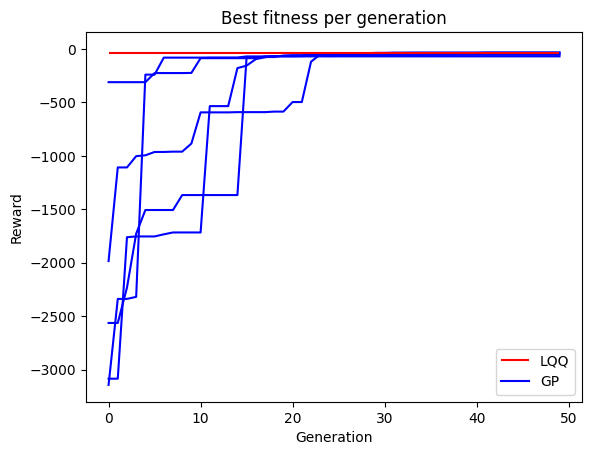

In [13]:
for i in range(n_seeds):
        plt.plot(-1*best_fitnesses[i], color="blue")
plt.hlines(jnp.mean(jnp.array(all_rewards_lq))*env.dt, 0, generations-1, color="red", label=env_type)
plt.plot(0, 0, label=f"GP", color="blue")
plt.title("Best fitness per generation")
plt.xlabel("Generation")
plt.ylabel("Reward")
plt.legend()
plt.show()

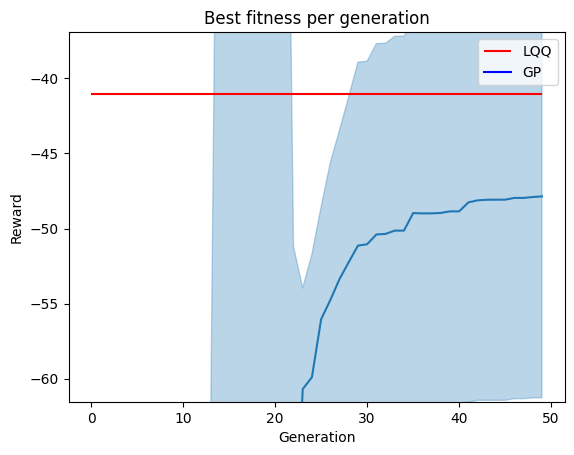

In [19]:
mean_fitnesses = jnp.mean(-1*best_fitnesses, axis=0)
std_fitnesses = jnp.std(-1*best_fitnesses, axis=0)

plt.plot(jnp.arange(generations), mean_fitnesses, color=f'C0')
plt.fill_between(jnp.arange(generations), mean_fitnesses-std_fitnesses, jnp.clip(mean_fitnesses+std_fitnesses,None,0), color='C0', alpha=0.3)
plt.hlines(jnp.mean(jnp.array(all_rewards_lq))*env.dt, 0, generations-1, color="red", label=env_type)
plt.plot(0, 0, label=f"GP", color="blue")
plt.title("Best fitness per generation")
plt.xlabel("Generation")
plt.ylabel("Reward")
plt.legend()
plt.ylim(jnp.mean(jnp.array(all_rewards_lq))*env.dt*1.5,jnp.mean(jnp.array(all_rewards_lq))*env.dt*0.9)
plt.show()

In [15]:
# sol = gp._to_string(['**', ['+', [jnp.array(-0.6194223)], [jnp.array(-1.1587586)]], ['-', [jnp.array(-1.5952332)], [jnp.array(7.43564)]]])
# jnp.array(-1.7781809),
def my_to_string(sol):
    expr = sympy.parsing.sympy_parser.parse_expr(sol,evaluate=True)

# print(gp.reconstruct(expr,mode="Mul"))
    return gp.simplify_algebra(gp.reconstruct(expr,mode="Mul"))[0]


['a0/6.6014814', 'x0+((target-a1)+((a0*-2.4376426)+((x1+a1)/-3.2978795)))'], readout = [[1.9943408 0.6555286]]
-67.63381


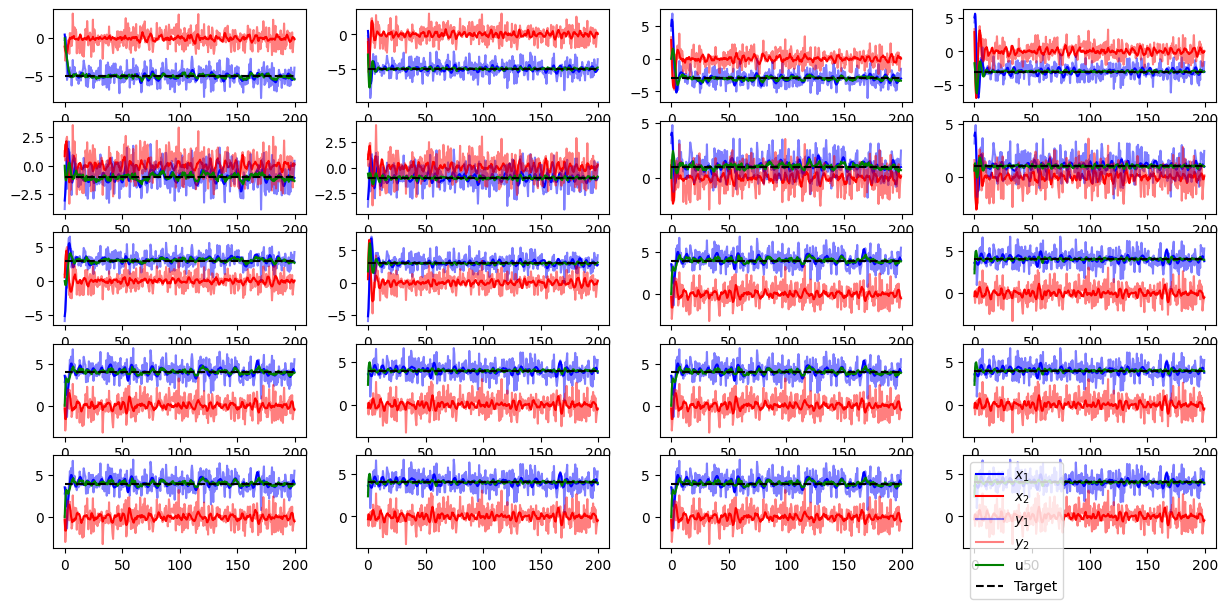

In [16]:
data, env, fitness_function, rewards_lq, state_obs_control_lq = get_data(seed, env_type, T=200)
x0,ts,targets,noise_keys=data

# sol = multi_gp.Expression([my_to_string('-4.0*a0 - 4.20*target + 3.0*x1'),my_to_string('a1**2.0')],jnp.array([[-0.98,0.20]]))

# xs_gp, ys_gp, us_gp, act = jax.vmap(gp.evaluate_control_loop, in_axes=[None,0,None, 0, 0])(sol, x0, ts, targets, noise_keys)
index = 0
print(best_solutions[index])
xs_gp, ys_gp, us_gp, act = jax.vmap(gp.evaluate_control_loop, in_axes=[None,0,None, 0, 0])(best_solutions[index], x0, ts, targets, noise_keys)
rewards_gp = jax.vmap(fitness_function.get_rewards)(xs_gp, us_gp, targets)
print(jnp.mean(rewards_gp,axis=0)[-1]*dt)
fig, ax = plt.subplots(ncols=4,nrows=5, figsize=(15,7))
ax = ax.ravel()

xs_lq, ys_lq, us_lq = state_obs_control_lq
for i in range(x0.shape[0]):
    index = 2*i
    ax[index].plot(ts,xs_gp[index,:,0], label='$x_1$', color='blue')
    ax[index].plot(ts,xs_gp[index,:,1], label='$x_2$', color='red')
    ax[index].plot(ts,ys_gp[index,:,0], label='$y_1$', alpha=0.5, color='blue')
    ax[index].plot(ts,ys_gp[index,:,1], label='$y_2$', alpha=0.5, color='red')
    ax[index].plot(ts,us_gp[index], label='u', color='green')
    ax[index].hlines(targets[index], ts[0], ts[-1], color="black", linestyle="--", label="Target")

    ax[index+1].plot(ts,xs_lq[index,:,0], label='$x_1$', color='blue')
    ax[index+1].plot(ts,xs_lq[index,:,1], label='$x_2$', color='red')
    ax[index+1].plot(ts,ys_lq[index,:,0], label='$y_1$', alpha=0.5, color='blue')
    ax[index+1].plot(ts,ys_lq[index,:,1], label='$y_2$', alpha=0.5, color='red')
    ax[index+1].plot(ts,us_lq[index], label='u', color='green')
    ax[index+1].hlines(targets[index], ts[0], ts[-1], color="black", linestyle="--", label="Target")
ax[-1].legend()
plt.show()

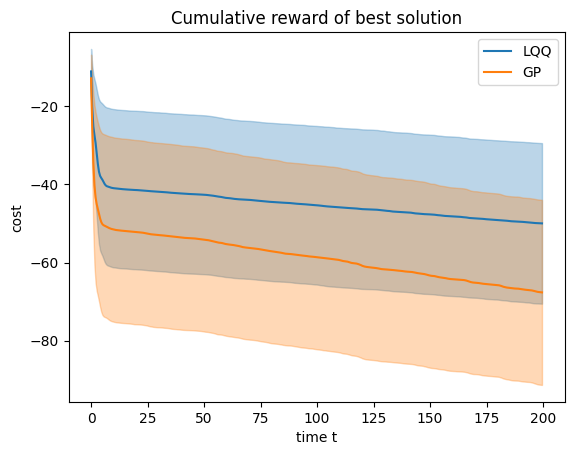

In [17]:
mean_rewards_lq = jnp.mean(rewards_lq*dt, axis=0)
std_rewards_lq = jnp.std(rewards_lq*dt, axis=0)*dt

plt.plot(ts, mean_rewards_lq, label=env_type, color=f'C0')
plt.fill_between(ts, mean_rewards_lq-std_rewards_lq,  mean_rewards_lq+std_rewards_lq, color='C0', alpha=0.3)

mean_rewards_gp = jnp.mean(rewards_gp*dt, axis=0)
std_rewards_gp = jnp.std(rewards_gp*dt, axis=0)*dt

plt.plot(ts, mean_rewards_gp, label=f'GP', alpha=1., color=f'C1')
plt.fill_between(ts, mean_rewards_gp-std_rewards_gp,  mean_rewards_gp+std_rewards_gp, color='C1', alpha=0.3)

plt.xlabel('time t')
plt.ylabel('cost')
plt.title('Cumulative reward of best solution')
plt.legend()
plt.show()